In [119]:
!ls /content/drive/MyDrive/datasets/

# Імпортуємо необхідні бібліотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error
from google.colab import drive
drive.mount('/content/drive')




austr.jpg	  combined_data.csv  House_Rent_Dataset.csv  weatherAUS.csv
chatbot_logs.csv  datasets	     second_austr.jpg
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [120]:
# Завантажуємо датасет
df_camp = pd.read_csv('/content/drive/MyDrive/datasets/datasets/dim_campaigns.csv')
df_prod = pd.read_csv('/content/drive/MyDrive/datasets/datasets/dim_products.csv')
df_stores = pd.read_csv('/content/drive/MyDrive/datasets/datasets/dim_stores.csv')
df_events = pd.read_csv('/content/drive/MyDrive/datasets/datasets/fact_events.csv')


In [121]:
print(df_camp.head(5))
print(df_prod.head(5))
print(df_stores.head(5))
print(df_events.head(5))

   campaign_id campaign_name  start_date    end_date
0  CAMP_DIW_01        Diwali  12-11-2023  18-11-2023
1  CAMP_SAN_01     Sankranti  10-01-2024  16-01-2024
  product_code                     product_name           category
0          P01           Atliq_Masoor_Dal (1KG)  Grocery & Staples
1          P02     Atliq_Sonamasuri_Rice (10KG)  Grocery & Staples
2          P03          Atliq_Suflower_Oil (1L)  Grocery & Staples
3          P04     Atliq_Farm_Chakki_Atta (1KG)  Grocery & Staples
4          P05  Atliq_Scrub_Sponge_For_Dishwash          Home Care
  store_id           city
0  STTRV-0     Trivandrum
1  STMDU-3        Madurai
2  STHYD-6      Hyderabad
3  STVSK-1  Visakhapatnam
4  STCBE-3     Coimbatore
  event_id store_id  campaign_id product_code  base_price(before_promo)  \
0   8481be  STCHE-1  CAMP_DIW_01          P04                       290   
1   20618e  STCHE-3  CAMP_SAN_01          P04                       370   
2   f30579  STBLR-9  CAMP_DIW_01          P02             

In [122]:
df_events.head(5)

,event_id,store_id,campaign_id,product_code,base_price(before_promo),quantity_sold(before_promo),promo_type,base_price(after_promo),quantity_sold(after_promo)
0,8481be,STCHE-1,CAMP_DIW_01,P04,290,327.0,25% OFF,217,287
1,20618e,STCHE-3,CAMP_SAN_01,P04,370,379.0,BOGOF,185,1622
2,f30579,STBLR-9,CAMP_DIW_01,P02,860,337.0,33% OFF,576,488
3,4f570c,STBLR-7,CAMP_DIW_01,P05,55,122.0,25% OFF,41,107
4,6d153f,STHYD-5,CAMP_SAN_01,P15,3000,122.0,500 Cashback,2500,272


In [123]:
# prompt: # prompt: . The operations team wants to ensure the integrity of the events data by removing
# # duplicates. Check for and remove duplicate rows in the events dataframe based
# # on store_id, campaign_id, and product_code. How many duplicate rows were
# # removed?

# Count initial number of rows
initial_rows = df_events.shape[0]

# Remove duplicate rows based on specified columns
df_events_no_duplicates = df_events.drop_duplicates(subset=['store_id', 'campaign_id', 'product_code'])

# Count number of rows after removing duplicates
rows_after_removing_duplicates = df_events_no_duplicates.shape[0]

# Calculate the number of duplicate rows removed
duplicate_rows_removed = initial_rows - rows_after_removing_duplicates

print(f"Number of duplicate rows removed: {duplicate_rows_removed}")

# Update the original dataframe (optional, depending on whether you want to keep the original)
df_events = df_events_no_duplicates

Number of duplicate rows removed: 10


In [124]:
# prompt: How many cities have more than 5 stores?

# Group by city and count the number of stores
city_store_counts = df_stores.groupby('city')['store_id'].count()

# Filter for cities with more than 5 stores
cities_with_more_than_5_stores = city_store_counts[city_store_counts > 5]

# Count the number of such cities
num_cities = len(cities_with_more_than_5_stores)

print(f"Number of cities with more than 5 stores: {num_cities}")

Number of cities with more than 5 stores: 3


In [125]:
# prompt: The sales team has identified missing values in the quantity_sold(before_promo)
# data. Estimate these values using the median quantity sold before the promotion.
# How many missing values were filled, and what is the median used for
# imputation?

# Identify rows with missing quantity_sold(before_promo)
missing_before_promo = df_events['quantity_sold(before_promo)'].isnull()
num_missing_before_imputation = missing_before_promo.sum()

# Calculate the median of quantity_sold(before_promo) excluding missing values
median_before_promo = df_events['quantity_sold(before_promo)'].median()

# Impute missing values with the median
df_events['quantity_sold(before_promo)'] = df_events['quantity_sold(before_promo)'].fillna(median_before_promo)

# Count the number of missing values filled
num_missing_after_imputation = df_events['quantity_sold(before_promo)'].isnull().sum()
num_filled = num_missing_before_imputation - num_missing_after_imputation

print(f"Number of missing values filled: {num_filled}")
print(f"Median used for imputation: {median_before_promo}")


Number of missing values filled: 20
Median used for imputation: 78.0


In [126]:
# prompt: 4. Identify the product category with the lowest base price before the promotion.

import pandas as pd

# Print the columns of df_prod to verify the base price column name
print("Columns in df_prod:", df_prod.columns)

# Merge df_prod with df_events on product_code
merged_df = pd.merge(df_events, df_prod, on='product_code')

# Group by product category and calculate the average base price before promotion
# Assuming the column name identified from printing df_prod.columns is correct
# Replace 'base_price' below with the actual column name if it's different
avg_base_price_by_category = merged_df.groupby('category')['base_price(before_promo)'].mean()

# Find the product category with the lowest average base price
lowest_price_category = avg_base_price_by_category.idxmin()
lowest_price_value = avg_base_price_by_category.min()

print(f"Product category with the lowest base price before the promotion: {lowest_price_category}")
print(f"Lowest base price: {lowest_price_value}")

Columns in df_prod: Index(['product_code', 'product_name', 'category'], dtype='object')
Product category with the lowest base price before the promotion: Personal Care
Lowest base price: 102.375


In [127]:
# prompt:  What is the total quantity sold after the promotion for the BOGOF promo type
# during the Diwali campaign?

import pandas as pd
# Merge df_events with df_camp on campaign_id
merged_events_campaign = pd.merge(df_events, df_camp, on='campaign_id')

# Filter for the 'Diwali' campaign and 'BOGOF' promo type
diwali_bogof_sales = merged_events_campaign[
    (merged_events_campaign['campaign_name'] == 'Diwali') &
    (merged_events_campaign['promo_type'] == 'BOGOF')
]

# Calculate the total quantity sold after the promotion for the filtered data
total_quantity_sold_after_promo = diwali_bogof_sales['quantity_sold(after_promo)'].sum()

print(f"Total quantity sold after the promotion for BOGOF promo during Diwali campaign: {total_quantity_sold_after_promo}")


Total quantity sold after the promotion for BOGOF promo during Diwali campaign: 34461


In [128]:
# prompt: . Which store recorded the highest quantity sold after the promotion during the
# Diwali campaign?

import pandas as pd
# Merge df_events with df_camp and df_stores on their respective IDs
merged_df_full = pd.merge(df_events, df_camp, on='campaign_id')
merged_df_full = pd.merge(merged_df_full, df_stores, on='store_id')

# Filter for the 'Diwali' campaign
diwali_sales = merged_df_full[merged_df_full['campaign_name'] == 'Diwali']

# Group by store and calculate the sum of quantity sold after the promotion
store_diwali_sales = diwali_sales.groupby('store_id')['quantity_sold(after_promo)'].sum()

# Find the store with the highest total quantity sold after the promotion
highest_selling_store_id = store_diwali_sales.idxmax()
highest_selling_quantity = store_diwali_sales.max()

# Get the store name for the highest selling store
highest_selling_store_name = df_stores[df_stores['store_id'] == highest_selling_store_id]['store_id'].iloc[0]

print(f"The store with the highest quantity sold after the promotion during the Diwali campaign is: {highest_selling_store_name} (Store ID: {highest_selling_store_id})")
print(f"Quantity sold after promotion: {highest_selling_quantity}")

The store with the highest quantity sold after the promotion during the Diwali campaign is: STCHE-4 (Store ID: STCHE-4)
Quantity sold after promotion: 5013


In [129]:
# prompt: . Understand which campaigns had the most successful outcomes. Compare the
# total quantities sold before and after the promotions for the Sankranti and Diwali
# campaigns. Which campaign saw a greater increase in sales?

# Filter data for Sankranti and Diwali campaigns
sankranti_diwali_df = merged_events_campaign[
    merged_events_campaign['campaign_name'].isin(['Sankranti', 'Diwali'])
]

# Calculate total quantity sold before and after promotion for each campaign
campaign_sales_summary = sankranti_diwali_df.groupby('campaign_name').agg(
    total_quantity_before_promo=('quantity_sold(before_promo)', 'sum'),
    total_quantity_after_promo=('quantity_sold(after_promo)', 'sum')
).reset_index()

# Calculate the increase in sales for each campaign
campaign_sales_summary['sales_increase'] = campaign_sales_summary['total_quantity_after_promo'] - campaign_sales_summary['total_quantity_before_promo']

print("Sales Summary for Sankranti and Diwali Campaigns:")
print(campaign_sales_summary)

# Determine which campaign saw a greater increase in sales
greater_increase_campaign = campaign_sales_summary.loc[campaign_sales_summary['sales_increase'].idxmax()]

print(f"\nThe campaign with a greater increase in sales was: {greater_increase_campaign['campaign_name']}")
print(f"Sales Increase: {greater_increase_campaign['sales_increase']}")

Sales Summary for Sankranti and Diwali Campaigns:
  campaign_name  total_quantity_before_promo  total_quantity_after_promo  \
0        Diwali                     109756.0                      183404   
1     Sankranti                      97894.0                      252069   

   sales_increase  
0         73648.0  
1        154175.0  

The campaign with a greater increase in sales was: Sankranti
Sales Increase: 154175.0


In [130]:
# Client Request 8: Highest IR% Product (Sankranti)
# --------------------------
# Step 1: Merge events and campaigns data
merged_camp = pd.merge(df_events, df_camp, on='campaign_id')

# Step 2: Filter for Sankranti campaign
sankranti = merged_camp[merged_camp['campaign_name'] == 'Sankranti']

# Step 3: Merge with product data
merged_sankranti = pd.merge(sankranti, df_prod, on='product_code')

# Step 4: Define discount logic
discount_map = {
    'BOGOF': 0.5,
    '5% OFF': 0.05,
    '10% OFF': 0.10,
    '25% OFF': 0.25,
    '500 Cashback': lambda x: max(0, x - 500)
}

def calculate_revenue_after(row):
    promo = row['promo_type']
    base_price = row['base_price(before_promo)']
    qty = row['quantity_sold(after_promo)']

    if promo == '500 Cashback':
        return (base_price - 500) * qty
    elif promo in discount_map:
        return base_price * (1 - discount_map[promo]) * qty
    else:
        return base_price * qty

# Step 5: Calculate revenues
merged_sankranti['revenue_before'] = merged_sankranti['quantity_sold(before_promo)'] * merged_sankranti['base_price(before_promo)']
merged_sankranti['revenue_after'] = merged_sankranti.apply(calculate_revenue_after, axis=1)

# Step 6: Calculate IR%
product_ir = merged_sankranti.groupby(['product_code', 'product_name']).agg(
    total_before=('revenue_before', 'sum'),
    total_after=('revenue_after', 'sum')
)
product_ir['IR%'] = ((product_ir['total_after'] - product_ir['total_before']) / product_ir['total_before']) * 100

# Step 7: Find top product
top_product = product_ir['IR%'].idxmax()
top_ir_percentage = product_ir.loc[top_product, 'IR%']

print(f"8. Product with highest IR%: {top_product[1]} ({top_product[0]}) - IR%: {top_ir_percentage:.2f}%")

8. Product with highest IR%: Atliq_Suflower_Oil (1L) (P03) - IR%: 91.83%


<ipython-input-131-229cd511ae2a>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


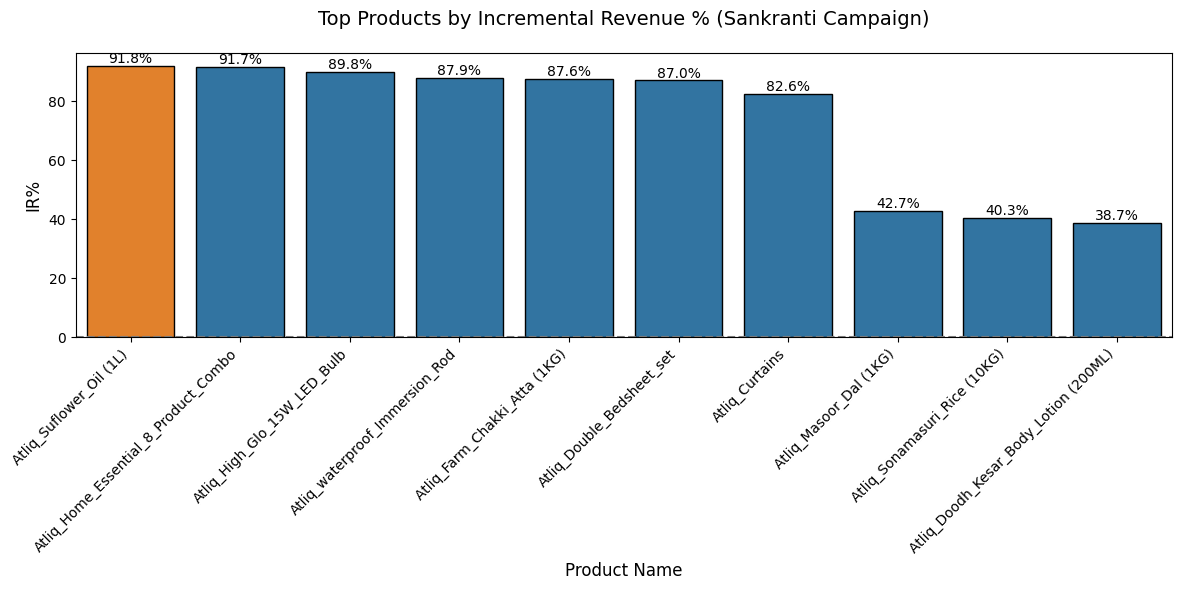

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort products by IR% and select top 10 for visualization
product_ir_sorted = product_ir.sort_values('IR%', ascending=False).head(10).reset_index()

# Customize bar colors
colors = ['#1f77b4' if x != top_product[1] else '#ff7f0e' for x in product_ir_sorted['product_name']]

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    x='product_name',
    y='IR%',
    data=product_ir_sorted,
    palette=colors,
    edgecolor='black'
)

# Annotate values
for index, value in enumerate(product_ir_sorted['IR%']):
    plt.text(
        index,
        value + 1 if value > 0 else value - 5,
        f'{value:.1f}%',
        ha='center',
        fontsize=10
    )

# Customize plot
plt.title('Top Products by Incremental Revenue % (Sankranti Campaign)', fontsize=14, pad=20)
plt.xlabel('Product Name', fontsize=12)
plt.ylabel('IR%', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.axhline(0, color='gray', linestyle='--')
plt.tight_layout()

plt.show()

In [132]:
# prompt: . Which store in Visakhapatnam recorded the lowest Incremental Sold Units
# Percentage (ISU%) during the Diwali campaign? What is the ISU% for that
# store?

import numpy as np
# Filter data for the Diwali campaign and Visakhapatnam stores
visakhapatnam_diwali_df = merged_df_full[
    (merged_df_full['campaign_name'] == 'Diwali') &
    (merged_df_full['city'] == 'Visakhapatnam')
].copy()

# Calculate Incremental Sold Units (ISU)
visakhapatnam_diwali_df['incremental_sold_units'] = visakhapatnam_diwali_df['quantity_sold(after_promo)'] - visakhapatnam_diwali_df['quantity_sold(before_promo)']

# Group by store and calculate total ISU and total quantity sold before promo
store_visakhapatnam_diwali_summary = visakhapatnam_diwali_df.groupby('store_id').agg(
    total_isu=('incremental_sold_units', 'sum'),
    total_quantity_before_promo=('quantity_sold(before_promo)', 'sum')
).reset_index()

# Calculate Incremental Sold Units Percentage (ISU%)
store_visakhapatnam_diwali_summary['isu_percentage'] = (store_visakhapatnam_diwali_summary['total_isu'] / store_visakhapatnam_diwali_summary['total_quantity_before_promo']) * 100
store_visakhapatnam_diwali_summary.replace([np.inf, -np.inf], 0, inplace=True) # Handle division by zero

# Find the store with the lowest ISU%
lowest_isu_store = store_visakhapatnam_diwali_summary.loc[store_visakhapatnam_diwali_summary['isu_percentage'].idxmin()]

# Get the store name for the lowest ISU% store
lowest_isu_store_id = lowest_isu_store['store_id']
lowest_isu_store_name = df_stores[df_stores['store_id'] == lowest_isu_store_id]['store_id'].iloc[0]
lowest_isu_value = lowest_isu_store['isu_percentage']

print(f"The store in Visakhapatnam with the lowest Incremental Sold Units Percentage (ISU%) during the Diwali campaign is: {lowest_isu_store_name} (Store ID: {lowest_isu_store_id})")
print(f"The ISU% for this store is: {lowest_isu_value:.2f}%")

The store in Visakhapatnam with the lowest Incremental Sold Units Percentage (ISU%) during the Diwali campaign is: STVSK-3 (Store ID: STVSK-3)
The ISU% for this store is: 49.21%


In [138]:
# Filter for the 'Sankranti' campaign only
sankranti_df = merged_df_full[merged_df_full['campaign_name'] == 'Sankranti'].copy()

# Fill missing values with 0 to avoid computation errors
sankranti_df[['base_price(before_promo)', 'base_price(after_promo)',
              'quantity_sold(before_promo)', 'quantity_sold(after_promo)']] = \
    sankranti_df[['base_price(before_promo)', 'base_price(after_promo)',
                  'quantity_sold(before_promo)', 'quantity_sold(after_promo)']].fillna(0)

# Calculate revenue before and after promotion
sankranti_df['revenue_before'] = sankranti_df['base_price(before_promo)'] * sankranti_df['quantity_sold(before_promo)']
sankranti_df['revenue_after'] = sankranti_df['base_price(after_promo)'] * sankranti_df['quantity_sold(after_promo)']

# Group by promo type and compute aggregated metrics
promo_summary = sankranti_df.groupby('promo_type').agg({
    'revenue_before': 'sum',
    'revenue_after': 'sum',
    'quantity_sold(before_promo)': 'sum',
    'quantity_sold(after_promo)': 'sum'
}).reset_index()

# Compute IR% and ISU% safely
promo_summary = promo_summary[(promo_summary['revenue_before'] > 0) & (promo_summary['quantity_sold(before_promo)'] > 0)].copy()
promo_summary['IR%'] = ((promo_summary['revenue_after'] - promo_summary['revenue_before']) / promo_summary['revenue_before']) * 100
promo_summary['ISU%'] = ((promo_summary['quantity_sold(after_promo)'] - promo_summary['quantity_sold(before_promo)']) / promo_summary['quantity_sold(before_promo)']) * 100

# Filter promo types with both IR% and ISU% negative
negative_impact_promos = promo_summary[(promo_summary['IR%'] < 0) & (promo_summary['ISU%'] < 0)]

# Output result
if not negative_impact_promos.empty:
    for _, row in negative_impact_promos.iterrows():
        print(f"Promo Type with negative IR% and ISU%: {row['promo_type']}")
        print(f"IR%: {row['IR%']:.2f}%")
        print(f"ISU%: {row['ISU%']:.2f}%\n")
else:
    print("No promo type had both negative IR% and ISU% during the Sankranti campaign.")


Promo Type with negative IR% and ISU%: 25% OFF
IR%: -39.33%
ISU%: -19.60%

